In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab_Notebooks/DL_project/'

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/DL_project


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [3]:
!pip install peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer, TrainingArguments, AdamW, get_scheduler
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
import time
from torch.utils.data import Subset

In [5]:
raw_datasets = load_dataset('glue', 'cola') # type: datasets.dataset_dict.DatasetDict
raw_datasets['train'][0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.",
 'label': 1,
 'idx': 0}

In [8]:
SMS_OOD_data = load_dataset('sms_spam', trust_remote_code=True)

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [9]:
# Function to load and parse out-of-domain COLA dataset
'''
\cite: https://github.com/uds-lsv/llmft/blob/main/task_utils.py
'''
def load_cola_ood_dataset(path, label=None, cache_dir=None):
    data_files = {"validation": path}
    dataset = load_dataset("csv", data_files=data_files, sep="\t", column_names=[
                           'code', 'label', 'annotation', 'sentence'], cache_dir=cache_dir)
    dataset = dataset["validation"]

    # cola-ood comes without indices, so we add them
    indices = list(range(len(dataset)))
    dataset = dataset.add_column(name="idx", column=indices)

    subset = "cola-ood"

    if label is not None:  # filter dataset based on label
        dataset = dataset.filter(
            lambda example: example["label"] == label)
        subset = f"{subset}-{'acceptable' if label == 1 else 'unacceptable'}"

    return dataset, subset

In [10]:
eval_ood_data, _ = load_cola_ood_dataset(path='dev.tsv')

Generating validation split: 0 examples [00:00, ? examples/s]

In [11]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")

def tokenize_function(examples):
    return tokenizer(examples['sentence'], max_length=512, padding='max_length', truncation=True)

def tokenize_OOD(examples):
    return tokenizer(examples['sentence'], max_length=512, padding='max_length', truncation=True)

def tokenize_SMS_OOD(examples):
    return tokenizer(examples['sms'], max_length=512, padding='max_length', truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_OOD = eval_ood_data.map(tokenize_OOD, batched=True)
OOD_dataset = tokenized_OOD
tokenized_SMS_OOD = SMS_OOD_data.map(tokenize_SMS_OOD, batched=True)
#tokenized_datasets['train'][0]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [12]:
def generate_context(dateset, number = 3):
    context_dataset = dateset.shuffle(seed=24).select(range(number))
    instruction_context = 'Here are some examples:\n'

    for i in range(len(context_dataset)):
        sentence = context_dataset[i]['sentence']
        label = context_dataset[i]['label']
        instruction_context += f'{i+1}. Sentence: {sentence} Label: {label}\n'

    instruction_context += "\n Based on the examples, given the below sentence, does it return a label of 0 or 1?"
    return instruction_context

def OOD_generate_context(dataset, number = 3):
    context_dataset = dataset.shuffle(seed=24).select(range(number))
    instruction_context = 'Here are some examples:\n'

    for i in range(len(context_dataset)):
        sentence = context_dataset[i]['sms']
        label = context_dataset[i]['label']
        instruction_context += f'{i+1}. SMS: {sentence} Label: {label}\n'

    instruction_context += "\n Based on the examples, given the below sms, does it return a label of 0 or 1?"
    return instruction_context


def create_batches(data, batch_size):
    num_batches = len(data) // batch_size
    batches = [data[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

    if len(data) % batch_size != 0:
        batches.append(data[num_batches * batch_size:])

    return batches


def distillation_loss(student_logits, teacher_logits, temperature=2.0):
    teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
    student_log_probs = F.log_softmax(student_logits / temperature, dim=-1)
    loss = F.kl_div(student_log_probs, teacher_probs, reduction="batchmean") * (temperature ** 2)
    return loss


def save_checkpoint(context_size, model, optimizer, epoch, path='checkpoint.pth'):
    state = {
        'context_size': context_size,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, path)
    print(f"Checkpoint saved at {path}")


def generate_accuracy(model, data):
    correct_predictions = 0
    total_predictions = 0

    for batch in data:
        labels = torch.tensor(batch["label"]).to(device)
        inputs = torch.tensor(batch["input_ids"]).to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
import pandas as pd

context_size = [2, 16, 32, 64, 128]
seeds = [2219, 2967, 4717, 3996, 158]

warmup_ratio = 0.1
batch_size = 12
learningRate = 1e-4
lora_config_r8 = LoraConfig(r=8, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)

result = pd.DataFrame(columns=["n", "seed", "context_distillation_in_domain_accuracy",
              "context_distillation_out_of_domain_accuracy_dev",
              "context_distillation_out_of_domain_accuracy_sms",
              "In_context_learning_in_domain_accuracy",
              "In_context_learning_out_of_domain_accuracy_dev",
              "In_context_learning_out_of_domain_accuracy_sms",
              "run_time"])

for n in context_size:
    for seed in seeds:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        train_dataset = tokenized_datasets['train'].shuffle(seed=seed).select(range(300))
        validation_dataset = tokenized_datasets["validation"]
        OOD_dataset = tokenized_OOD
        SMS_OOD_dataset = tokenized_SMS_OOD['train'] #.shuffle(seed=seed).select(range(500))

        context = generate_context(train_dataset, n)

        def attach_context(input):
          encoding = tokenizer([f'{context} Sentence: {text} Label:'
                              for text in input["sentence"]],
                              truncation=True, max_length=512, padding="max_length", return_tensors='pt')
          input["input_ids"] = encoding["input_ids"].squeeze()
          input["attention_mask"] = encoding["attention_mask"].squeeze()
          return input

        def SMS_OOD_attach_context(input):
          encoding = tokenizer([f'{context} SMS: {text} Label:'
                              for text in input["sms"]],
                              truncation=True, max_length=512, padding="max_length", return_tensors='pt')
          input["input_ids"] = encoding["input_ids"].squeeze()
          input["attention_mask"] = encoding["attention_mask"].squeeze()
          return input

        train_data_with_context = train_dataset.map(attach_context, batched=True)
        validation_data_with_context = validation_dataset.map(attach_context, batched=True)
        OOD_data_with_context = OOD_dataset.map(attach_context, batched=True)
        SMS_OOD_data_with_context = SMS_OOD_dataset.map(SMS_OOD_attach_context, batched=True)

        batched_train = create_batches(train_dataset, batch_size)
        batched_train_with_context = create_batches(train_data_with_context, batch_size)
        batched_test = create_batches(Subset(validation_dataset, list(range(500,1000))), batch_size)
        batched_test_with_context = create_batches(Subset(validation_data_with_context, list(range(500,1000))), batch_size)
        batched_OOD = create_batches(OOD_dataset, batch_size)
        batched_OOD_with_context = create_batches(OOD_data_with_context, batch_size)
        batched_SMS_OOD = create_batches(SMS_OOD_dataset, batch_size)
        batched_SMS_OOD_with_context = create_batches(SMS_OOD_data_with_context, batch_size)

        teacher_model = AutoModelForSequenceClassification.from_pretrained("facebook/opt-125m", num_labels=2)
        #teacher_model = get_peft_model(teacher_model, lora_config_r8)
        student_model = AutoModelForSequenceClassification.from_pretrained("facebook/opt-125m", num_labels=2)
        #student_model = get_peft_model(student_model, lora_config_r8)
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        teacher_model.to(device)
        student_model.to(device)

        optimizer = torch.optim.AdamW(student_model.parameters(), lr=learningRate)
        num_epochs = 30    #different
        num_training_steps = num_epochs * len(batched_train)

        total_steps = (len(train_dataset) // batch_size) * num_epochs
        warmup_steps = int(warmup_ratio * num_training_steps)  # total_steps)

        lr_scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps = warmup_steps,
            num_training_steps=num_training_steps
        )

        start_time = time.time()

        teacher_model.eval()
        for epoch in range(num_epochs):
            student_model.train()
            i = 0

            for batch, context_batch in zip(batched_train, batched_train_with_context):
                i += 1
                #print(batch)
                labels = torch.tensor(batch["label"]).to(device)
                inputs_student = torch.tensor(batch["input_ids"]).to(device)
                inputs_teacher = torch.tensor(context_batch["input_ids"]).to(device)

                #with torch.no_grad():
                teacher_outputs = teacher_model(inputs_teacher)
                student_outputs = student_model(inputs_student)

                loss = distillation_loss(student_outputs.logits, teacher_outputs.logits)
                #print(loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            lr_scheduler.step()
            # Evaluation
            student_model.eval()
            correct_predictions = 0
            total_predictions = 0
            with torch.no_grad():
                acc = generate_accuracy(student_model, batched_test)

            print(f"context size of {n} Seed {seed} Epoch {epoch+1}/{num_epochs} - Accuracy: {acc:.4f}")

        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Context_distillation training time: {elapsed_time:.2f} seconds for a context size of {n}")

        #save_checkpoint(n, student_model, optimizer, epoch, path=f'checkpoint_epoch_{epoch}.pth')
        acc_without_tune = generate_accuracy(teacher_model, batched_test)
        print(f"Context_distillation in-domain accuracy: {acc:.4f} for a context size of {n}")
        print(f"in-domain accuracy without tuning: {acc_without_tune:.4f} for a context size of {n}")

        OOD_acc = generate_accuracy(student_model, batched_OOD)
        OOD_acc_without_tuning = generate_accuracy(teacher_model, batched_OOD)
        print(f"Context_distillation out-of-domain accuracy: {OOD_acc:.4f} for a context size of {n}")
        print(f"out-of-domain accuracy without tuning: {OOD_acc_without_tuning:.4f} for a context size of {n}")

        SMS_OOD_acc = generate_accuracy(student_model, batched_SMS_OOD)
        SMS_OOD_acc_without_tuning = generate_accuracy(teacher_model, batched_SMS_OOD)
        print(f"Context_distillation SMS out-of-domain accuracy: {SMS_OOD_acc:.4f} for a context size of {n}")
        print(f"SMS out-of-domain accuracy without tuning: {SMS_OOD_acc_without_tuning:.4f} for a context size of {n}")

        ##In-context learning
        ICL_in_domain_acc = generate_accuracy(teacher_model, batched_test_with_context)
        print(f"In-context learning in-domain accuracy: {ICL_in_domain_acc:.4f} for a context size of {n}")

        ICL_OOD_acc = generate_accuracy(teacher_model, batched_OOD_with_context)
        print(f"In-context learning out-of-domain accuracy: {ICL_OOD_acc:.4f} for a context size of {n}")

        ICL_SMS_OOD_acc = generate_accuracy(teacher_model, batched_SMS_OOD_with_context)
        print(f"In-context learning SMS out-of-domain accuracy: {ICL_SMS_OOD_acc:.4f} for a context size of {n}")

        result_new = pd.DataFrame({
              "n": [n],
              "seed" : [seed],
              "context_distillation_in_domain_accuracy": [acc],
              "context_distillation_out_of_domain_accuracy_dev": [OOD_acc],
              "context_distillation_out_of_domain_accuracy_sms": [SMS_OOD_acc],
              "In_context_learning_in_domain_accuracy": [ICL_in_domain_acc],
              "In_context_learning_out_of_domain_accuracy_dev": [ICL_OOD_acc],
              "In_context_learning_out_of_domain_accuracy_sms": [ICL_SMS_OOD_acc],
              "run_time": [elapsed_time],
              "in-domain accuracy without tuning": [acc_without_tune],
              "out-of-domain accuracy without tuning": [OOD_acc_without_tuning],
              "SMS out-of-domain accuracy without tuning": [SMS_OOD_acc_without_tuning]
            })
        result = pd.concat([result, result_new], ignore_index=True)

result.to_csv("Context_learning_lora_result_nolora.csv")
print('Finished training!!')

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


context size of 2 Seed 2219 Epoch 1/30 - Accuracy: 0.3240
context size of 2 Seed 2219 Epoch 2/30 - Accuracy: 0.6420
context size of 2 Seed 2219 Epoch 3/30 - Accuracy: 0.6620
context size of 2 Seed 2219 Epoch 4/30 - Accuracy: 0.6660
context size of 2 Seed 2219 Epoch 5/30 - Accuracy: 0.6780
context size of 2 Seed 2219 Epoch 6/30 - Accuracy: 0.6800
context size of 2 Seed 2219 Epoch 7/30 - Accuracy: 0.6740
context size of 2 Seed 2219 Epoch 8/30 - Accuracy: 0.6760
context size of 2 Seed 2219 Epoch 9/30 - Accuracy: 0.6760
context size of 2 Seed 2219 Epoch 10/30 - Accuracy: 0.6760
context size of 2 Seed 2219 Epoch 11/30 - Accuracy: 0.6760
context size of 2 Seed 2219 Epoch 12/30 - Accuracy: 0.6740
context size of 2 Seed 2219 Epoch 13/30 - Accuracy: 0.6820
context size of 2 Seed 2219 Epoch 14/30 - Accuracy: 0.6800
context size of 2 Seed 2219 Epoch 15/30 - Accuracy: 0.6840
context size of 2 Seed 2219 Epoch 16/30 - Accuracy: 0.6820
context size of 2 Seed 2219 Epoch 17/30 - Accuracy: 0.6820
contex

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


context size of 2 Seed 2967 Epoch 1/30 - Accuracy: 0.3460
context size of 2 Seed 2967 Epoch 2/30 - Accuracy: 0.4580
context size of 2 Seed 2967 Epoch 3/30 - Accuracy: 0.4060
context size of 2 Seed 2967 Epoch 4/30 - Accuracy: 0.3980
context size of 2 Seed 2967 Epoch 5/30 - Accuracy: 0.3940
context size of 2 Seed 2967 Epoch 6/30 - Accuracy: 0.3760
context size of 2 Seed 2967 Epoch 7/30 - Accuracy: 0.3700
context size of 2 Seed 2967 Epoch 8/30 - Accuracy: 0.3660
context size of 2 Seed 2967 Epoch 9/30 - Accuracy: 0.3800
context size of 2 Seed 2967 Epoch 10/30 - Accuracy: 0.3640
context size of 2 Seed 2967 Epoch 11/30 - Accuracy: 0.3700
context size of 2 Seed 2967 Epoch 12/30 - Accuracy: 0.3940
context size of 2 Seed 2967 Epoch 13/30 - Accuracy: 0.3220
context size of 2 Seed 2967 Epoch 14/30 - Accuracy: 0.3280
context size of 2 Seed 2967 Epoch 15/30 - Accuracy: 0.3820
context size of 2 Seed 2967 Epoch 16/30 - Accuracy: 0.3320
context size of 2 Seed 2967 Epoch 17/30 - Accuracy: 0.3240
contex

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


context size of 2 Seed 4717 Epoch 1/30 - Accuracy: 0.3200
context size of 2 Seed 4717 Epoch 2/30 - Accuracy: 0.3600
context size of 2 Seed 4717 Epoch 3/30 - Accuracy: 0.3240
context size of 2 Seed 4717 Epoch 4/30 - Accuracy: 0.3340
context size of 2 Seed 4717 Epoch 5/30 - Accuracy: 0.3240
context size of 2 Seed 4717 Epoch 6/30 - Accuracy: 0.3220
context size of 2 Seed 4717 Epoch 7/30 - Accuracy: 0.3220
context size of 2 Seed 4717 Epoch 8/30 - Accuracy: 0.3200
context size of 2 Seed 4717 Epoch 9/30 - Accuracy: 0.3220
context size of 2 Seed 4717 Epoch 10/30 - Accuracy: 0.3200
context size of 2 Seed 4717 Epoch 11/30 - Accuracy: 0.3200
context size of 2 Seed 4717 Epoch 12/30 - Accuracy: 0.3160
context size of 2 Seed 4717 Epoch 13/30 - Accuracy: 0.3380
context size of 2 Seed 4717 Epoch 14/30 - Accuracy: 0.3200
context size of 2 Seed 4717 Epoch 15/30 - Accuracy: 0.3180
context size of 2 Seed 4717 Epoch 16/30 - Accuracy: 0.3200
context size of 2 Seed 4717 Epoch 17/30 - Accuracy: 0.3320
contex

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


context size of 2 Seed 3996 Epoch 1/30 - Accuracy: 0.4800
context size of 2 Seed 3996 Epoch 2/30 - Accuracy: 0.3240
context size of 2 Seed 3996 Epoch 3/30 - Accuracy: 0.3200
context size of 2 Seed 3996 Epoch 4/30 - Accuracy: 0.3220
context size of 2 Seed 3996 Epoch 5/30 - Accuracy: 0.3180
context size of 2 Seed 3996 Epoch 6/30 - Accuracy: 0.3200
context size of 2 Seed 3996 Epoch 7/30 - Accuracy: 0.3160
context size of 2 Seed 3996 Epoch 8/30 - Accuracy: 0.3160
context size of 2 Seed 3996 Epoch 9/30 - Accuracy: 0.3160
context size of 2 Seed 3996 Epoch 10/30 - Accuracy: 0.3180
context size of 2 Seed 3996 Epoch 11/30 - Accuracy: 0.3200
context size of 2 Seed 3996 Epoch 12/30 - Accuracy: 0.3180
context size of 2 Seed 3996 Epoch 13/30 - Accuracy: 0.3200
context size of 2 Seed 3996 Epoch 14/30 - Accuracy: 0.3160
context size of 2 Seed 3996 Epoch 15/30 - Accuracy: 0.3200
context size of 2 Seed 3996 Epoch 16/30 - Accuracy: 0.3180
context size of 2 Seed 3996 Epoch 17/30 - Accuracy: 0.3180
contex

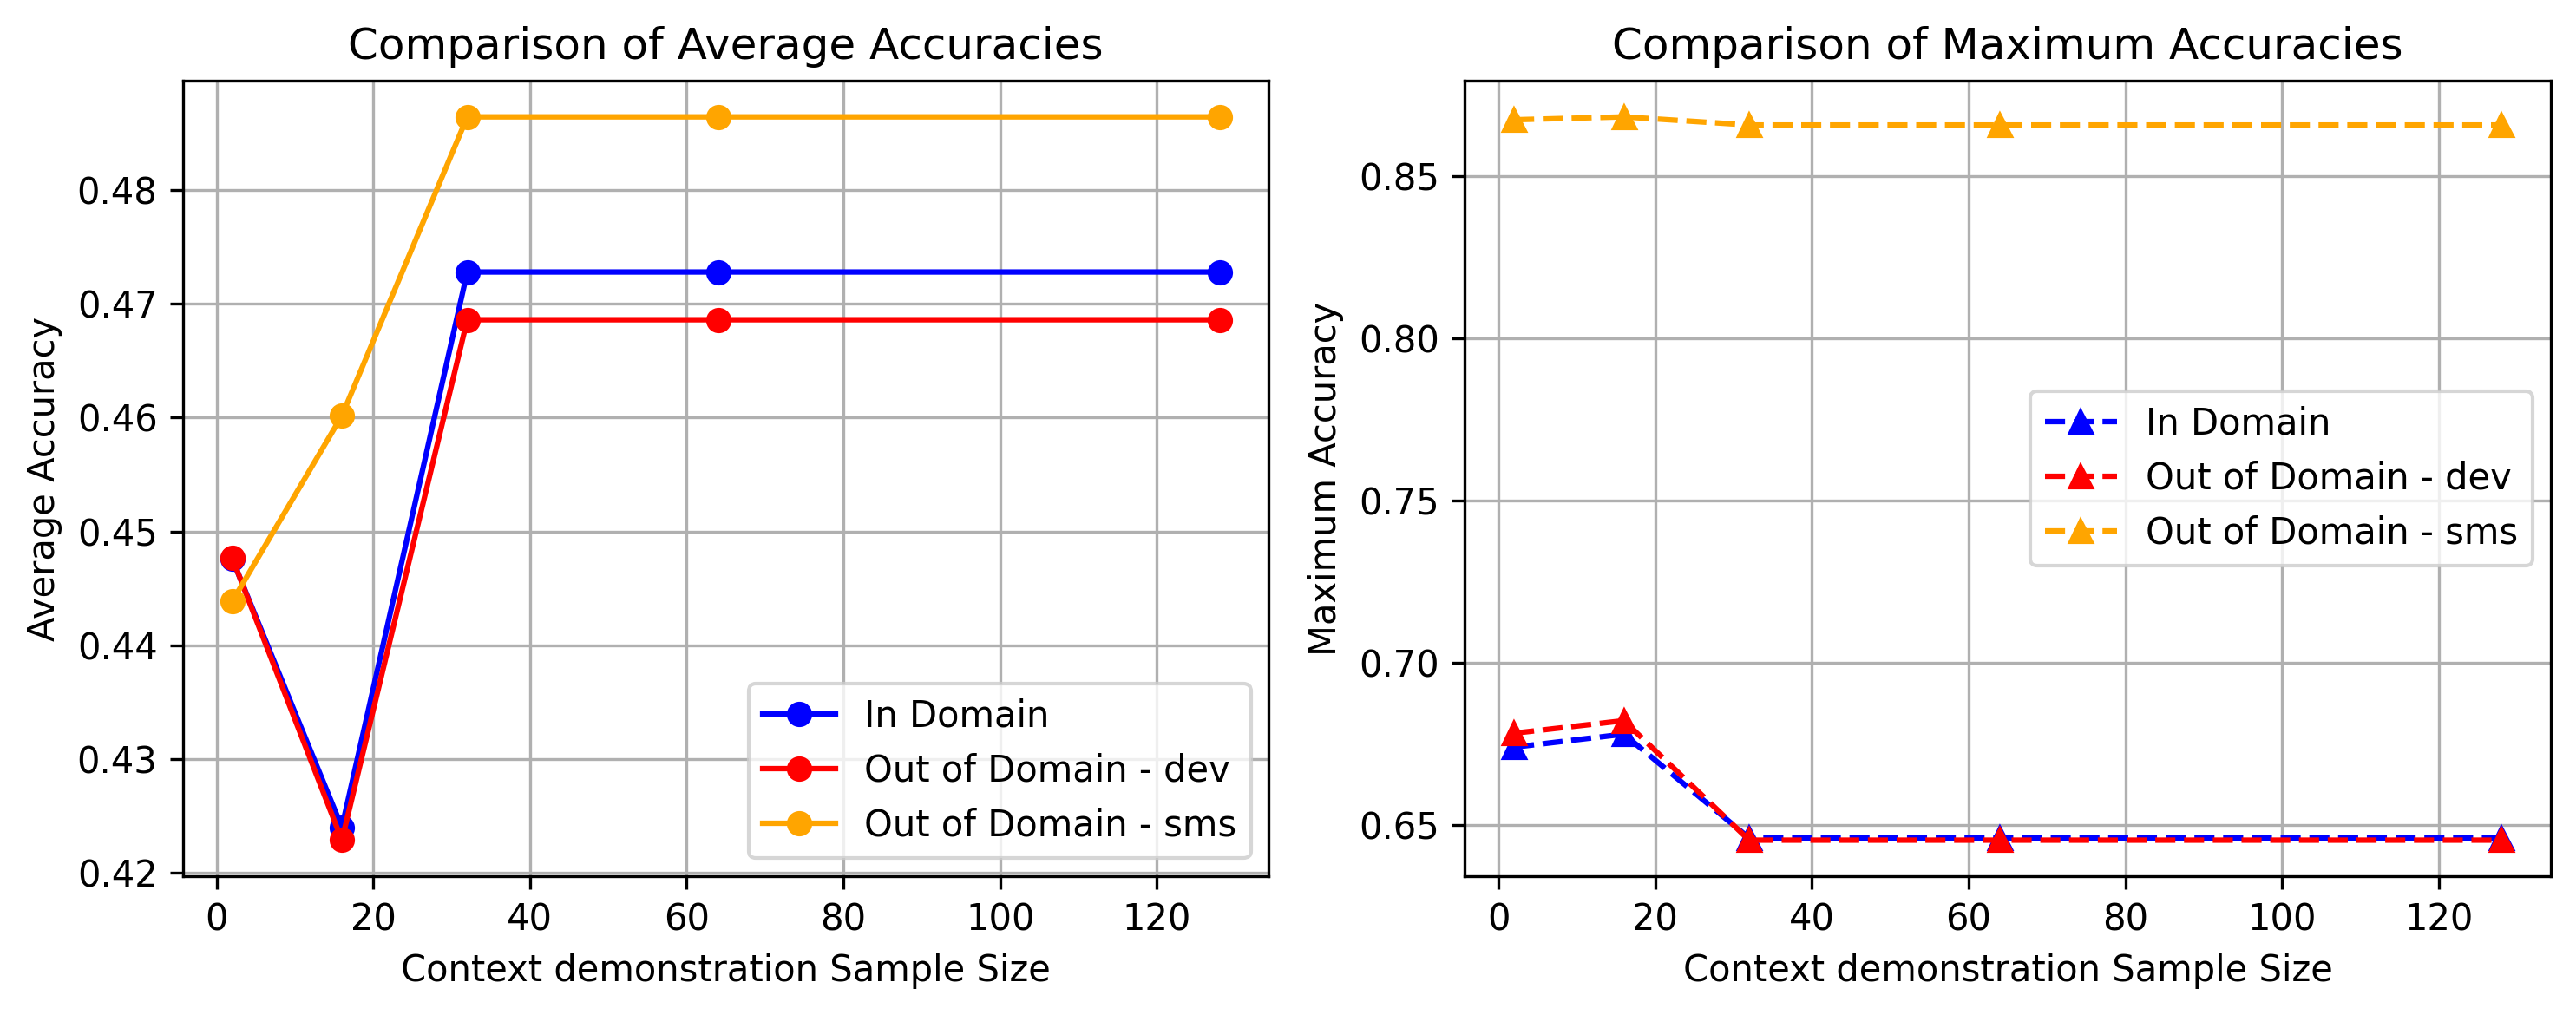

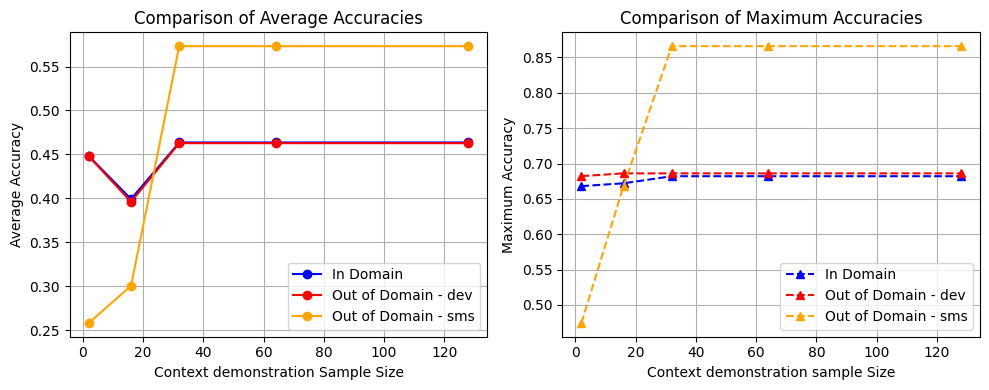

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

context_size=[2,16,32,64,128]
result= pd.read_csv("Context_learning_lora_result.csv")

# Group the results by 'n' and compute the average and maximum performance for each group
grouped_results = result.groupby('n')

def calculate_metrics(grouped_results, col):
    ave = grouped_results[col].mean()
    max = grouped_results[col].max()
    std = grouped_results[col].std()
    return ave, max, std

average_CD_in_domain_accuracy, maximum_CD_in_domain_accuracy, stdev_CD_in_domain_accuracy \
= calculate_metrics(grouped_results, 'context_distillation_in_domain_accuracy')

average_CD_out_of_domain_accuracy_dev, maximum_CD_out_of_domain_accuracy_dev, stdev_CD_out_of_domain_accuracy_dev \
= calculate_metrics(grouped_results, 'context_distillation_out_of_domain_accuracy_dev')

average_CD_out_of_domain_accuracy_sms, maximum_CD_out_of_domain_accuracy_sms, stdev_CD_out_of_domain_accuracy_sms \
= calculate_metrics(grouped_results, 'context_distillation_out_of_domain_accuracy_sms')

average_ICL_in_domain_accuracy, maximum_ICL_in_domain_accuracy, stdev_ICL_in_domain_accuracy \
= calculate_metrics(grouped_results, 'In_context_learning_in_domain_accuracy')

average_ICL_out_of_domain_accuracy_dev, maximum_ICL_out_of_domain_accuracy_dev, stdev_ICL_out_of_domain_accuracy_dev \
= calculate_metrics(grouped_results, 'In_context_learning_out_of_domain_accuracy_dev')

average_ICL_out_of_domain_accuracy_sms, maximum_ICL_out_of_domain_accuracy_sms, stdev_ICL_out_of_domain_accuracy_sms \
= calculate_metrics(grouped_results, 'In_context_learning_out_of_domain_accuracy_sms')

# Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

# Plotting accuracies
ax1.plot(context_size, average_CD_in_domain_accuracy, marker='o', color='blue', label='In Domain')
ax1.plot(context_size, average_CD_out_of_domain_accuracy_dev, marker='o', color='red', label='Out of Domain - dev')
ax1.plot(context_size, average_CD_out_of_domain_accuracy_sms, marker='o', color='orange', label='Out of Domain - sms')

ax1.set_xlabel('Context demonstration Sample Size')
ax1.set_ylabel('Average Accuracy')
ax1.set_title('Comparison of Average Accuracies')
ax1.legend()
ax1.grid(True)

# Plotting run times
ax2.plot(context_size, maximum_CD_in_domain_accuracy, marker='^', linestyle='--', color='blue', label='In Domain')
ax2.plot(context_size, maximum_CD_out_of_domain_accuracy_dev, marker='^', linestyle='--', color='red', label='Out of Domain - dev')
ax2.plot(context_size, maximum_CD_out_of_domain_accuracy_sms, marker='^', linestyle='--', color='orange', label='Out of Domain - sms')

ax2.set_xlabel('Context demonstration Sample Size')
ax2.set_ylabel('Maximum Accuracy')
ax2.set_title('Comparison of Maximum Accuracies')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.savefig("Contex_distillation_accuracy.png")

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 4))

# Plotting accuracies
ax3.plot(context_size, average_ICL_in_domain_accuracy, marker='o', color='blue', label='In Domain')
ax3.plot(context_size, average_ICL_out_of_domain_accuracy_dev, marker='o', color='red', label='Out of Domain - dev')
ax3.plot(context_size, average_ICL_out_of_domain_accuracy_sms, marker='o', color='orange', label='Out of Domain - sms')

ax3.set_xlabel('Context demonstration Sample Size')
ax3.set_ylabel('Average Accuracy')
ax3.set_title('Comparison of Average Accuracies')
ax3.legend()
ax3.grid(True)

# Plotting run times
ax4.plot(context_size, maximum_ICL_in_domain_accuracy, marker='^', linestyle='--', color='blue', label='In Domain')
ax4.plot(context_size, maximum_ICL_out_of_domain_accuracy_dev, marker='^', linestyle='--', color='red', label='Out of Domain - dev')
ax4.plot(context_size, maximum_ICL_out_of_domain_accuracy_sms, marker='^', linestyle='--', color='orange', label='Out of Domain - sms')

ax4.set_xlabel('Context demonstration sample Size')
ax4.set_ylabel('Maximum Accuracy')
ax4.set_title('Comparison of Maximum Accuracies')
ax4.legend()
ax4.grid(True)

# Adjust layout
plt.tight_layout()
plt.savefig("In_context_learning_accuracy.png")

In [14]:
context_size = [2, 16, 32, 64, 128]
seeds = [2219, 2967, 4717, 3996, 158]
for n in context_size:
  for seed in seeds:
          torch.manual_seed(seed)
          if torch.cuda.is_available():
              torch.cuda.manual_seed_all(seed)

          train_dataset = tokenized_datasets['train'].shuffle(seed=seed).select(range(300))
          validation_dataset = tokenized_datasets["validation"]
          OOD_dataset = tokenized_OOD
          SMS_OOD_dataset = tokenized_SMS_OOD['train'] #.shuffle(seed=seed).select(range(500))

          context = generate_context(train_dataset, n)
          print(f'context for size {n} and seed {seed}:\n')
          print(context)

context for size 2 and seed 2219:

Here are some examples:
1. Sentence: The bed on which Tom slept was hard. Label: 1
2. Sentence: Stacy hit a baseball to Julia. Label: 1

 Based on the examples, given the below sentence, does it return a label of 0 or 1?
context for size 2 and seed 2967:

Here are some examples:
1. Sentence: Maxwell isn't half the doctor that his sister is a psychologist and his father was. Label: 0
2. Sentence: Joe's neuroses bother his patrons, and Sally's neuroses do too. Label: 1

 Based on the examples, given the below sentence, does it return a label of 0 or 1?
context for size 2 and seed 4717:

Here are some examples:
1. Sentence: Can Fiona eat sauteed candy canes? Label: 1
2. Sentence: Susan wanted Jane to study German. Label: 1

 Based on the examples, given the below sentence, does it return a label of 0 or 1?
context for size 2 and seed 3996:

Here are some examples:
1. Sentence: Poseidon appears to own a dragon Label: 0
2. Sentence: She thought it was easy